<h1>SARIMA</h1>

In [1]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv("sales_5000000.csv")
df = df[['Order Date', 'Total Profit']]
df['Order Date'] = pd.to_datetime(df['Order Date'])

df.set_index('Order Date', inplace=True)

monthly_df = df['Total Profit'].resample('ME').sum().to_frame()

print("Index frequency:", monthly_df.index.freq)


Index frequency: <MonthEnd>


In [3]:
monthly_df

,Total Profit
Order Date,
2014-01-31,1.556656e+10
2014-02-28,1.402973e+10
2014-03-31,1.556248e+10
2014-04-30,1.510544e+10
2014-05-31,1.559264e+10
...,...
2024-05-31,1.558589e+10
2024-06-30,1.506300e+10
2024-07-31,1.553073e+10


In [4]:
train_data, test_data = train_test_split(monthly_df, test_size= 0.2, shuffle=False)

In [5]:
train_data

,Total Profit
Order Date,
2014-01-31,1.556656e+10
2014-02-28,1.402973e+10
2014-03-31,1.556248e+10
2014-04-30,1.510544e+10
2014-05-31,1.559264e+10
...,...
2022-03-31,1.557572e+10
2022-04-30,1.508754e+10
2022-05-31,1.565507e+10


In [6]:
test_data

,Total Profit
Order Date,
2022-08-31,1.561939e+10
2022-09-30,1.507442e+10
2022-10-31,1.561683e+10
2022-11-30,1.509961e+10
2022-12-31,1.562022e+10
2023-01-31,1.559258e+10
2023-02-28,1.407188e+10
2023-03-31,1.555777e+10
2023-04-30,1.512009e+10


In [7]:
test_data = test_data[:-1].copy()

In [8]:
from statsmodels.tsa.stattools import adfuller

# Stationarity Check
result = adfuller(monthly_df['Total Profit'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -1.0450695524510298
p-value: 0.7364735326792382


MAPE: 0.73%
MAPA (Accuracy): 99.27%
RMSE: 135430318.86
MinMax Error: 0.0073
MPE: -0.51%
Correlation: 0.9601


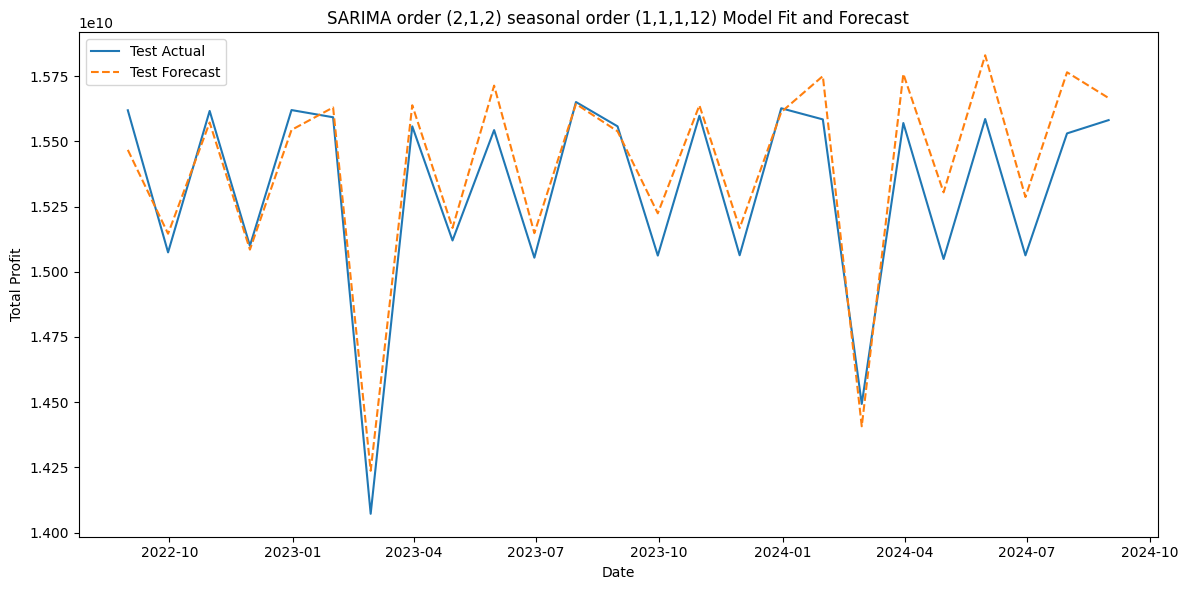

In [9]:
sarima_model = SARIMAX(train_data['Total Profit'], order=(2, 1, 2), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit()

# SARIMA Predictions
train_pred = sarima_result.predict(start=train_data.index[0], end=train_data.index[-1])
test_forecast = sarima_result.predict(start=test_data.index[0], end=test_data.index[-1])

y_true = test_data['Total Profit'].values
y_pred = test_forecast.values

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
accuracy = 100 - mape

min_vals = np.minimum(np.abs(y_true), np.abs(y_pred))
min_vals[min_vals == 0] = np.finfo(float).eps
minmax_errors = np.abs(y_true - y_pred) / min_vals
minmax_error = np.mean(minmax_errors)

mpe = np.mean((y_true - y_pred) / y_true) * 100

correlation = np.corrcoef(y_true, y_pred)[0, 1]

print(f"MAPE: {mape:.2f}%")
print(f"MAPA (Accuracy): {accuracy:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"MinMax Error: {minmax_error:.4f}")
print(f"MPE: {mpe:.2f}%")
print(f"Correlation: {correlation:.4f}")

plt.figure(figsize=(12,6))
plt.plot(test_data.index, test_data['Total Profit'], label='Test Actual')
plt.plot(test_data.index, test_forecast, label='Test Forecast', linestyle='--')

plt.title('SARIMA order (2,1,2) seasonal order (1,1,1,12) Model Fit and Forecast')
plt.xlabel('Date')
plt.ylabel('Total Profit')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
sarima_result.save('sarima_model.pkl')